In [2]:
from physDBD import ImportHelper, DataDesc, Params0GaussTraj, RxnInputsGaussLayer, \
    DParams0GaussTraj, RxnGaussModel, TrainingGaussData, DataTypeGauss
import numpy as np
import tensorflow as tf
import sys
import os
import datetime
import pickle
import matplotlib.pyplot as plt

In [3]:
data_dir = "stochastic_simulations/data/"

# Transformation

## Plot data

In [4]:
data_desc = DataDesc(
    seed_start_inc=1,
    seed_end_exc=2,
    time_start=0,
    time_end=100,
    time_interval=0.1,
    species=["H","P"]
)

data = ImportHelper.import_gillespie_ssa_from_data_desc(
    data_desc=data_desc,
    data_dir=data_dir,
    zero_padding=2
    )

Text(0.5, 0, 'Timepoint (x 0.1s)')

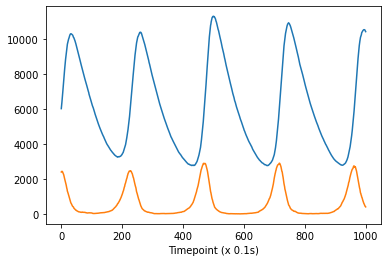

In [5]:
ex_traj = data[:,0]

plt.figure()
plt.plot(ex_traj)
plt.xlabel("Timepoint (x 0.1s)")

## Mean & Cov

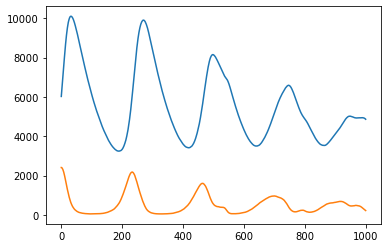

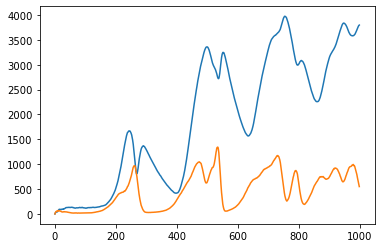

In [13]:
data_desc = DataDesc(
    seed_start_inc=0,
    seed_end_exc=25,
    time_start=0,
    time_end=100,
    time_interval=0.1,
    species=["H","P"]
    )

data = ImportHelper.import_gillespie_ssa_from_data_desc(
    data_desc=data_desc,
    data_dir=data_dir,
    zero_padding=2
    )

plt.figure()
plt.plot(np.mean(data[:,:,0],axis=1))
plt.plot(np.mean(data[:,:,1],axis=1))

plt.figure()
plt.plot(np.std(data[:,:,0],axis=1))
plt.plot(np.std(data[:,:,1],axis=1))

## Mean & chol decomp

In [6]:
data_desc = DataDesc(
    seed_start_inc=0,
    seed_end_exc=25,
    time_start=1,
    time_end=100,
    time_interval=0.1,
    species=["H","P"]
)

data = ImportHelper.import_gillespie_ssa_from_data_desc(
    data_desc=data_desc,
    data_dir=data_dir,
    zero_padding=2
    )

# Create params traj and export
params_traj = Params0GaussTraj.fromData(data, data_desc.times)

# Export
params_traj.export("cache/cache_params.txt")

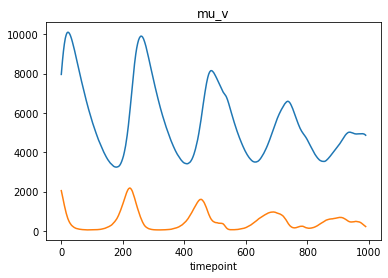

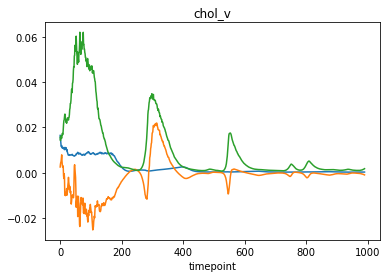

In [7]:
# Import params traj
params_traj = Params0GaussTraj.fromFile("cache/cache_params.txt", nv=2)

plt.figure()
plt.plot([x.mu_v[0] for x in params_traj.params0_traj])
plt.plot([x.mu_v[1] for x in params_traj.params0_traj])
plt.title("mu_v")
plt.xlabel("timepoint")
plt.savefig("figures/params_mu_v.png", dpi=200)

plt.figure()
plt.plot([x.chol_v[0,0] for x in params_traj.params0_traj])
plt.plot([x.chol_v[1,0] for x in params_traj.params0_traj])
plt.plot([x.chol_v[1,1] for x in params_traj.params0_traj])
plt.title("chol_v")
plt.xlabel("timepoint")
plt.savefig("figures/params_chol_v.png", dpi=200)

## Normalize parameters

Mu mean: [5553.90581818  505.66921212]
Mu std: [1872.36966102  481.2186396 ]
Cholv mean: [ 0.00221921 -0.00179991  0.00966707]
Cholv std: [0.00317884 0.00702268 0.01437919]


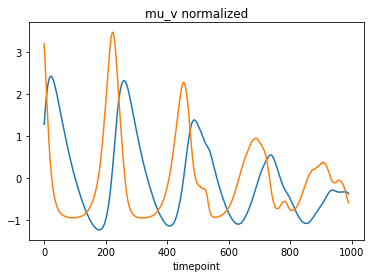

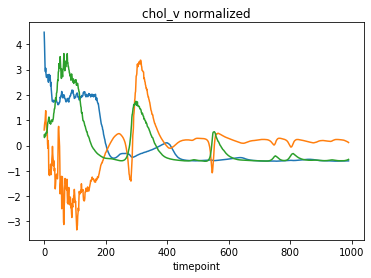

In [8]:
# Import params traj
params_traj = Params0GaussTraj.fromFile("cache/cache_params.txt", nv=2)

# Normalize
mu = np.array([x.mu_v for x in params_traj.params0_traj])
chol_v_vec = np.array([x.chol_v[np.tril_indices(2)] for x in params_traj.params0_traj])

mean_mu = np.mean(mu,axis=0)
mean_chol_v_vec = np.mean(chol_v_vec,axis=0)

stddev_mu = np.std(mu,axis=0)
stddev_chol_v_vec = np.std(chol_v_vec,axis=0)

print("Mu mean: " + str(mean_mu))
print("Mu std: " + str(stddev_mu))

print("Cholv mean: " + str(mean_chol_v_vec))
print("Cholv std: " + str(stddev_chol_v_vec))

# Export
np.savetxt("cache/trans_params_mean_mu.txt", mean_mu)
np.savetxt("cache/trans_params_mean_chol_v_vec.txt", mean_chol_v_vec)
np.savetxt("cache/trans_params_stddev_mu.txt", stddev_mu)
np.savetxt("cache/trans_params_stddev_chol_v_vec.txt", stddev_chol_v_vec)

# Normalize
for param0 in params_traj.params0_traj:
    param0.mu_v = ( param0.mu_v - mean_mu ) / stddev_mu
    param0.chol_v[0,0] = ( param0.chol_v[0,0] - mean_chol_v_vec[0] ) / stddev_chol_v_vec[0]
    param0.chol_v[1,0] = ( param0.chol_v[1,0] - mean_chol_v_vec[1] ) / stddev_chol_v_vec[1]
    param0.chol_v[1,1] = ( param0.chol_v[1,1] - mean_chol_v_vec[2] ) / stddev_chol_v_vec[2]

# Export
params_traj.export("cache/cache_params_norm.txt")

# Plot
plt.figure()
plt.plot([x.mu_v[0] for x in params_traj.params0_traj])
plt.plot([x.mu_v[1] for x in params_traj.params0_traj])
plt.title("mu_v normalized")
plt.xlabel("timepoint")
plt.savefig("figures/params_mu_v_norm.png", dpi=200)

plt.figure()
plt.plot([x.chol_v[0,0] for x in params_traj.params0_traj])
plt.plot([x.chol_v[1,0] for x in params_traj.params0_traj])
plt.plot([x.chol_v[1,1] for x in params_traj.params0_traj])
plt.title("chol_v normalized")
plt.xlabel("timepoint")
plt.savefig("figures/params_chol_v_norm.png", dpi=200)

# Derivatives

In [9]:
alphas = {
    "mu_v_0": 10.0,
    "mu_v_1": 10.0,
    "chol_v_0_0": 500.0,
    "chol_v_1_0": 500.0,
    "chol_v_1_1": 500.0
}
non_zero_vals = list(alphas.keys())

In [10]:
# Import params traj
params0_traj = Params0GaussTraj.fromFile("cache/cache_params_norm.txt", nv=2)

# Differentiate
dparams0_traj = params0_traj.differentiate_with_TVR(
    alphas=alphas, 
    no_opt_steps=10, 
    non_zero_vals=non_zero_vals
    )

# Export
dparams0_traj.export("cache/cache_params_norm_deriv.txt")

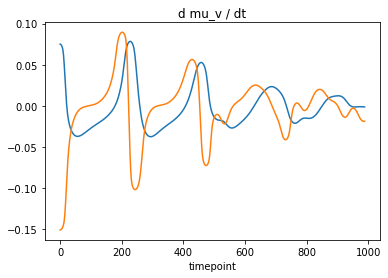

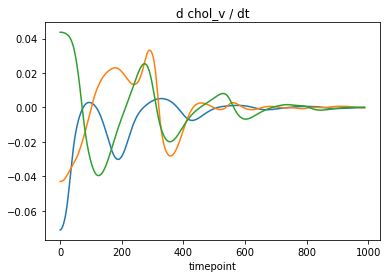

In [11]:
# Import params TE traj
dparams_traj = DParams0GaussTraj.fromFile("cache/cache_params_norm_deriv.txt", nv=2)

plt.figure()
plt.plot([x.dmu_v[0] for x in dparams_traj.dparams0_traj])
plt.plot([x.dmu_v[1] for x in dparams_traj.dparams0_traj])
plt.title("d mu_v / dt")
plt.xlabel("timepoint")
plt.savefig("figures/params_mu_v_norm_deriv.png", dpi=200)

plt.figure()
plt.plot([x.dchol_v[0,0] for x in dparams_traj.dparams0_traj])
plt.plot([x.dchol_v[1,0] for x in dparams_traj.dparams0_traj])
plt.plot([x.dchol_v[1,1] for x in dparams_traj.dparams0_traj])
plt.title("d chol_v / dt")
plt.xlabel("timepoint")
plt.savefig("figures/params_chol_v_norm_deriv.png", dpi=200)

## Re-integrate

In [12]:
# Import params and TE traj
params0_traj = Params0GaussTraj.fromFile("cache/cache_params_norm.txt", nv=2)
dparams0_traj = DParams0GaussTraj.fromFile("cache/cache_params_norm_deriv.txt", nv=2)

# Integrate
no_steps = len(params0_traj.params0_traj) - 1
params0_traj_filtered = Params0GaussTraj.fromIntegrating(
    dparams0_traj=dparams0_traj,
    params0_init=params0_traj.params0_traj[0],
    tpt_start=0,
    no_steps=no_steps,
    constant_vals_lf={}
    )

# Export
params0_traj_filtered.export("cache/cache_params_norm_filtered.txt")

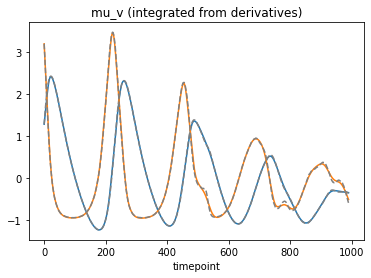

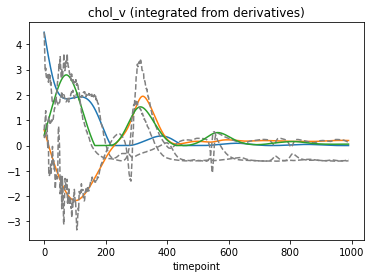

In [13]:
# Import params traj
params0_traj_filtered = Params0GaussTraj.fromFile("cache/cache_params_norm_filtered.txt", nv=2)
params0_traj = Params0GaussTraj.fromFile("cache/cache_params_norm.txt", nv=2)

plt.figure()
plt.plot([x.mu_v[0] for x in params0_traj_filtered.params0_traj])
plt.plot([x.mu_v[0] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.plot([x.mu_v[1] for x in params0_traj_filtered.params0_traj])
plt.plot([x.mu_v[1] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.title("mu_v (integrated from derivatives)")
plt.xlabel("timepoint")
plt.savefig("figures/params_mu_v_norm_filtered.png", dpi=200)

plt.figure()
plt.plot([x.chol_v[0,0] for x in params0_traj_filtered.params0_traj])
plt.plot([x.chol_v[0,0] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.plot([x.chol_v[1,0] for x in params0_traj_filtered.params0_traj])
plt.plot([x.chol_v[1,0] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.plot([x.chol_v[1,1] for x in params0_traj_filtered.params0_traj])
plt.plot([x.chol_v[1,1] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.title("chol_v (integrated from derivatives)")
plt.xlabel("timepoint")
plt.savefig("figures/params_chol_v_norm_filtered.png", dpi=200)

## Undo normalization on filtered

In [14]:
# Undo normalization on filtered
mean_mu = np.loadtxt("cache/trans_params_mean_mu.txt")
mean_chol_v_vec = np.loadtxt("cache/trans_params_mean_chol_v_vec.txt")
stddev_mu = np.loadtxt("cache/trans_params_stddev_mu.txt")
stddev_chol_v_vec = np.loadtxt("cache/trans_params_stddev_chol_v_vec.txt")

params0_traj_norm_filtered = Params0GaussTraj.fromFile("cache/cache_params_norm_filtered.txt", nv=2)

# Un-normalize
for param0 in params0_traj_norm_filtered.params0_traj:
    param0.mu_v = stddev_mu * param0.mu_v + mean_mu
    param0.chol_v[0,0] = stddev_chol_v_vec[0] * param0.chol_v[0,0] + mean_chol_v_vec[0]
    param0.chol_v[1,0] = stddev_chol_v_vec[1] * param0.chol_v[1,0] + mean_chol_v_vec[1]
    param0.chol_v[1,1] = stddev_chol_v_vec[2] * param0.chol_v[1,1] + mean_chol_v_vec[2]

# Export
params0_traj_norm_filtered.export("cache/cache_params_filtered.txt")


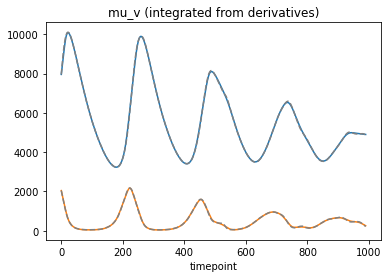

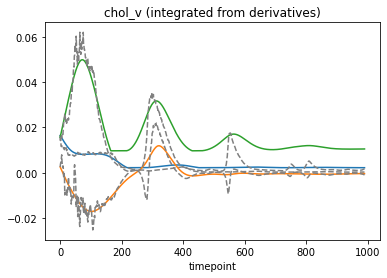

In [15]:
# Import params traj
params0_traj_filtered = Params0GaussTraj.fromFile("cache/cache_params_filtered.txt", nv=2)
params0_traj = Params0GaussTraj.fromFile("cache/cache_params.txt", nv=2)

plt.figure()
plt.plot([x.mu_v[0] for x in params0_traj_filtered.params0_traj])
plt.plot([x.mu_v[0] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.plot([x.mu_v[1] for x in params0_traj_filtered.params0_traj])
plt.plot([x.mu_v[1] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.title("mu_v (integrated from derivatives)")
plt.xlabel("timepoint")
plt.savefig("figures/params_mu_v_filtered.png", dpi=200)

plt.figure()
plt.plot([x.chol_v[0,0] for x in params0_traj_filtered.params0_traj])
plt.plot([x.chol_v[0,0] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.plot([x.chol_v[1,0] for x in params0_traj_filtered.params0_traj])
plt.plot([x.chol_v[1,0] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.plot([x.chol_v[1,1] for x in params0_traj_filtered.params0_traj])
plt.plot([x.chol_v[1,1] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.title("chol_v (integrated from derivatives)")
plt.xlabel("timepoint")
plt.savefig("figures/params_chol_v_filtered.png", dpi=200)

## Normalize derivs

In [16]:
# Import params TE traj
dparams_traj = DParams0GaussTraj.fromFile("cache/cache_params_norm_deriv.txt", nv=2)

# Normalize
dmu = np.array([x.dmu_v for x in dparams_traj.dparams0_traj])
dchol_v_vec = np.array([x.dchol_v[np.tril_indices(2)] for x in dparams_traj.dparams0_traj])

mean_dmu = np.mean(dmu,axis=0)
mean_dchol_v_vec = np.mean(dchol_v_vec,axis=0)

stddev_dmu = np.std(dmu,axis=0)
stddev_dchol_v_vec = np.std(dchol_v_vec,axis=0)

print("dmu mean: " + str(mean_dmu))
print("dmu std: " + str(stddev_dmu))

print("dcholv mean: " + str(mean_dchol_v_vec))
print("dcholv std: " + str(stddev_dchol_v_vec))

# Export
np.savetxt("cache/trans_params_norm_deriv_mean_dmu.txt", mean_dmu)
np.savetxt("cache/trans_params_norm_deriv_mean_dchol_v_vec.txt", mean_dchol_v_vec)
np.savetxt("cache/trans_params_norm_deriv_stddev_dmu.txt", stddev_dmu)
np.savetxt("cache/trans_params_norm_deriv_stddev_dchol_v_vec.txt", stddev_dchol_v_vec)

# Normalize
for dparam0 in dparams_traj.dparams0_traj:
    dparam0.dmu_v = ( dparam0.dmu_v - mean_dmu ) / stddev_dmu
    dparam0.dchol_v[0,0] = ( dparam0.dchol_v[0,0] - mean_dchol_v_vec[0] ) / stddev_dchol_v_vec[0]
    dparam0.dchol_v[1,0] = ( dparam0.dchol_v[1,0] - mean_dchol_v_vec[1] ) / stddev_dchol_v_vec[1]
    dparam0.dchol_v[1,1] = ( dparam0.dchol_v[1,1] - mean_dchol_v_vec[2] ) / stddev_dchol_v_vec[2]

# Export
dparams_traj.export("cache/cache_params_norm_deriv_norm.txt")

dmu mean: [-0.00164968 -0.0037534 ]
dmu std: [0.02667878 0.03903234]
dcholv mean: [-0.00515078 -0.0004204  -0.00101162]
dcholv std: [0.01319737 0.01504884 0.01596023]


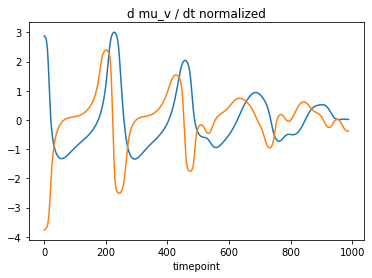

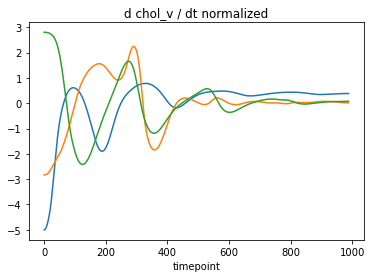

In [17]:
# Import params TE traj
dparams_traj = DParams0GaussTraj.fromFile("cache/cache_params_norm_deriv_norm.txt", nv=2)

plt.figure()
plt.plot([x.dmu_v[0] for x in dparams_traj.dparams0_traj])
plt.plot([x.dmu_v[1] for x in dparams_traj.dparams0_traj])
plt.title("d mu_v / dt normalized")
plt.xlabel("timepoint")
plt.savefig("figures/params_mu_v_norm_deriv_norm.png", dpi=200)

plt.figure()
plt.plot([x.dchol_v[0,0] for x in dparams_traj.dparams0_traj])
plt.plot([x.dchol_v[1,0] for x in dparams_traj.dparams0_traj])
plt.plot([x.dchol_v[1,1] for x in dparams_traj.dparams0_traj])
plt.title("d chol_v / dt normalized")
plt.xlabel("timepoint")
plt.savefig("figures/params_chol_v_norm_deriv_norm.png", dpi=200)